In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('data.csv')

# Analyzing data

In [2]:
df.head()

,EducationSector,IndividualProject,Age,Gender,City,Influenced,Perseverance,DesireToTakeInitiative,Competitiveness,SelfReliance,StrongNeedToAchieve,SelfConfidence,GoodPhysicalHealth,MentalDisorder,KeyTraits,ReasonsForLack,y
0,Engineering Sciences,No,19,Male,Yes,No,2,2,3,3,2,2,3,Yes,Passion,NaN,1
1,Engineering Sciences,Yes,22,Male,No,Yes,3,3,3,4,4,3,4,Yes,Vision,Just not interested! (Want to work in the corp...,0
2,Engineering Sciences,No,18,Male,Yes,No,3,4,3,3,3,4,4,No,Passion,Not willing to start a venture in India and wa...,0
3,Engineering Sciences,Yes,20,Male,Yes,Yes,3,3,3,3,4,3,3,No,Resilience,Not able to take a Financial Risk,0
4,Engineering Sciences,Yes,19,Male,Yes,Yes,2,3,3,3,4,3,2,Yes,Vision,NaN,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   EducationSector         219 non-null    object
 1   IndividualProject       219 non-null    object
 2   Age                     219 non-null    int64 
 3   Gender                  219 non-null    object
 4   City                    219 non-null    object
 5   Influenced              219 non-null    object
 6   Perseverance            219 non-null    int64 
 7   DesireToTakeInitiative  219 non-null    int64 
 8   Competitiveness         219 non-null    int64 
 9   SelfReliance            219 non-null    int64 
 10  StrongNeedToAchieve     219 non-null    int64 
 11  SelfConfidence          219 non-null    int64 
 12  GoodPhysicalHealth      219 non-null    int64 
 13  MentalDisorder          219 non-null    object
 14  KeyTraits               219 non-null    object
 15  Reason

# Features mapping and selection

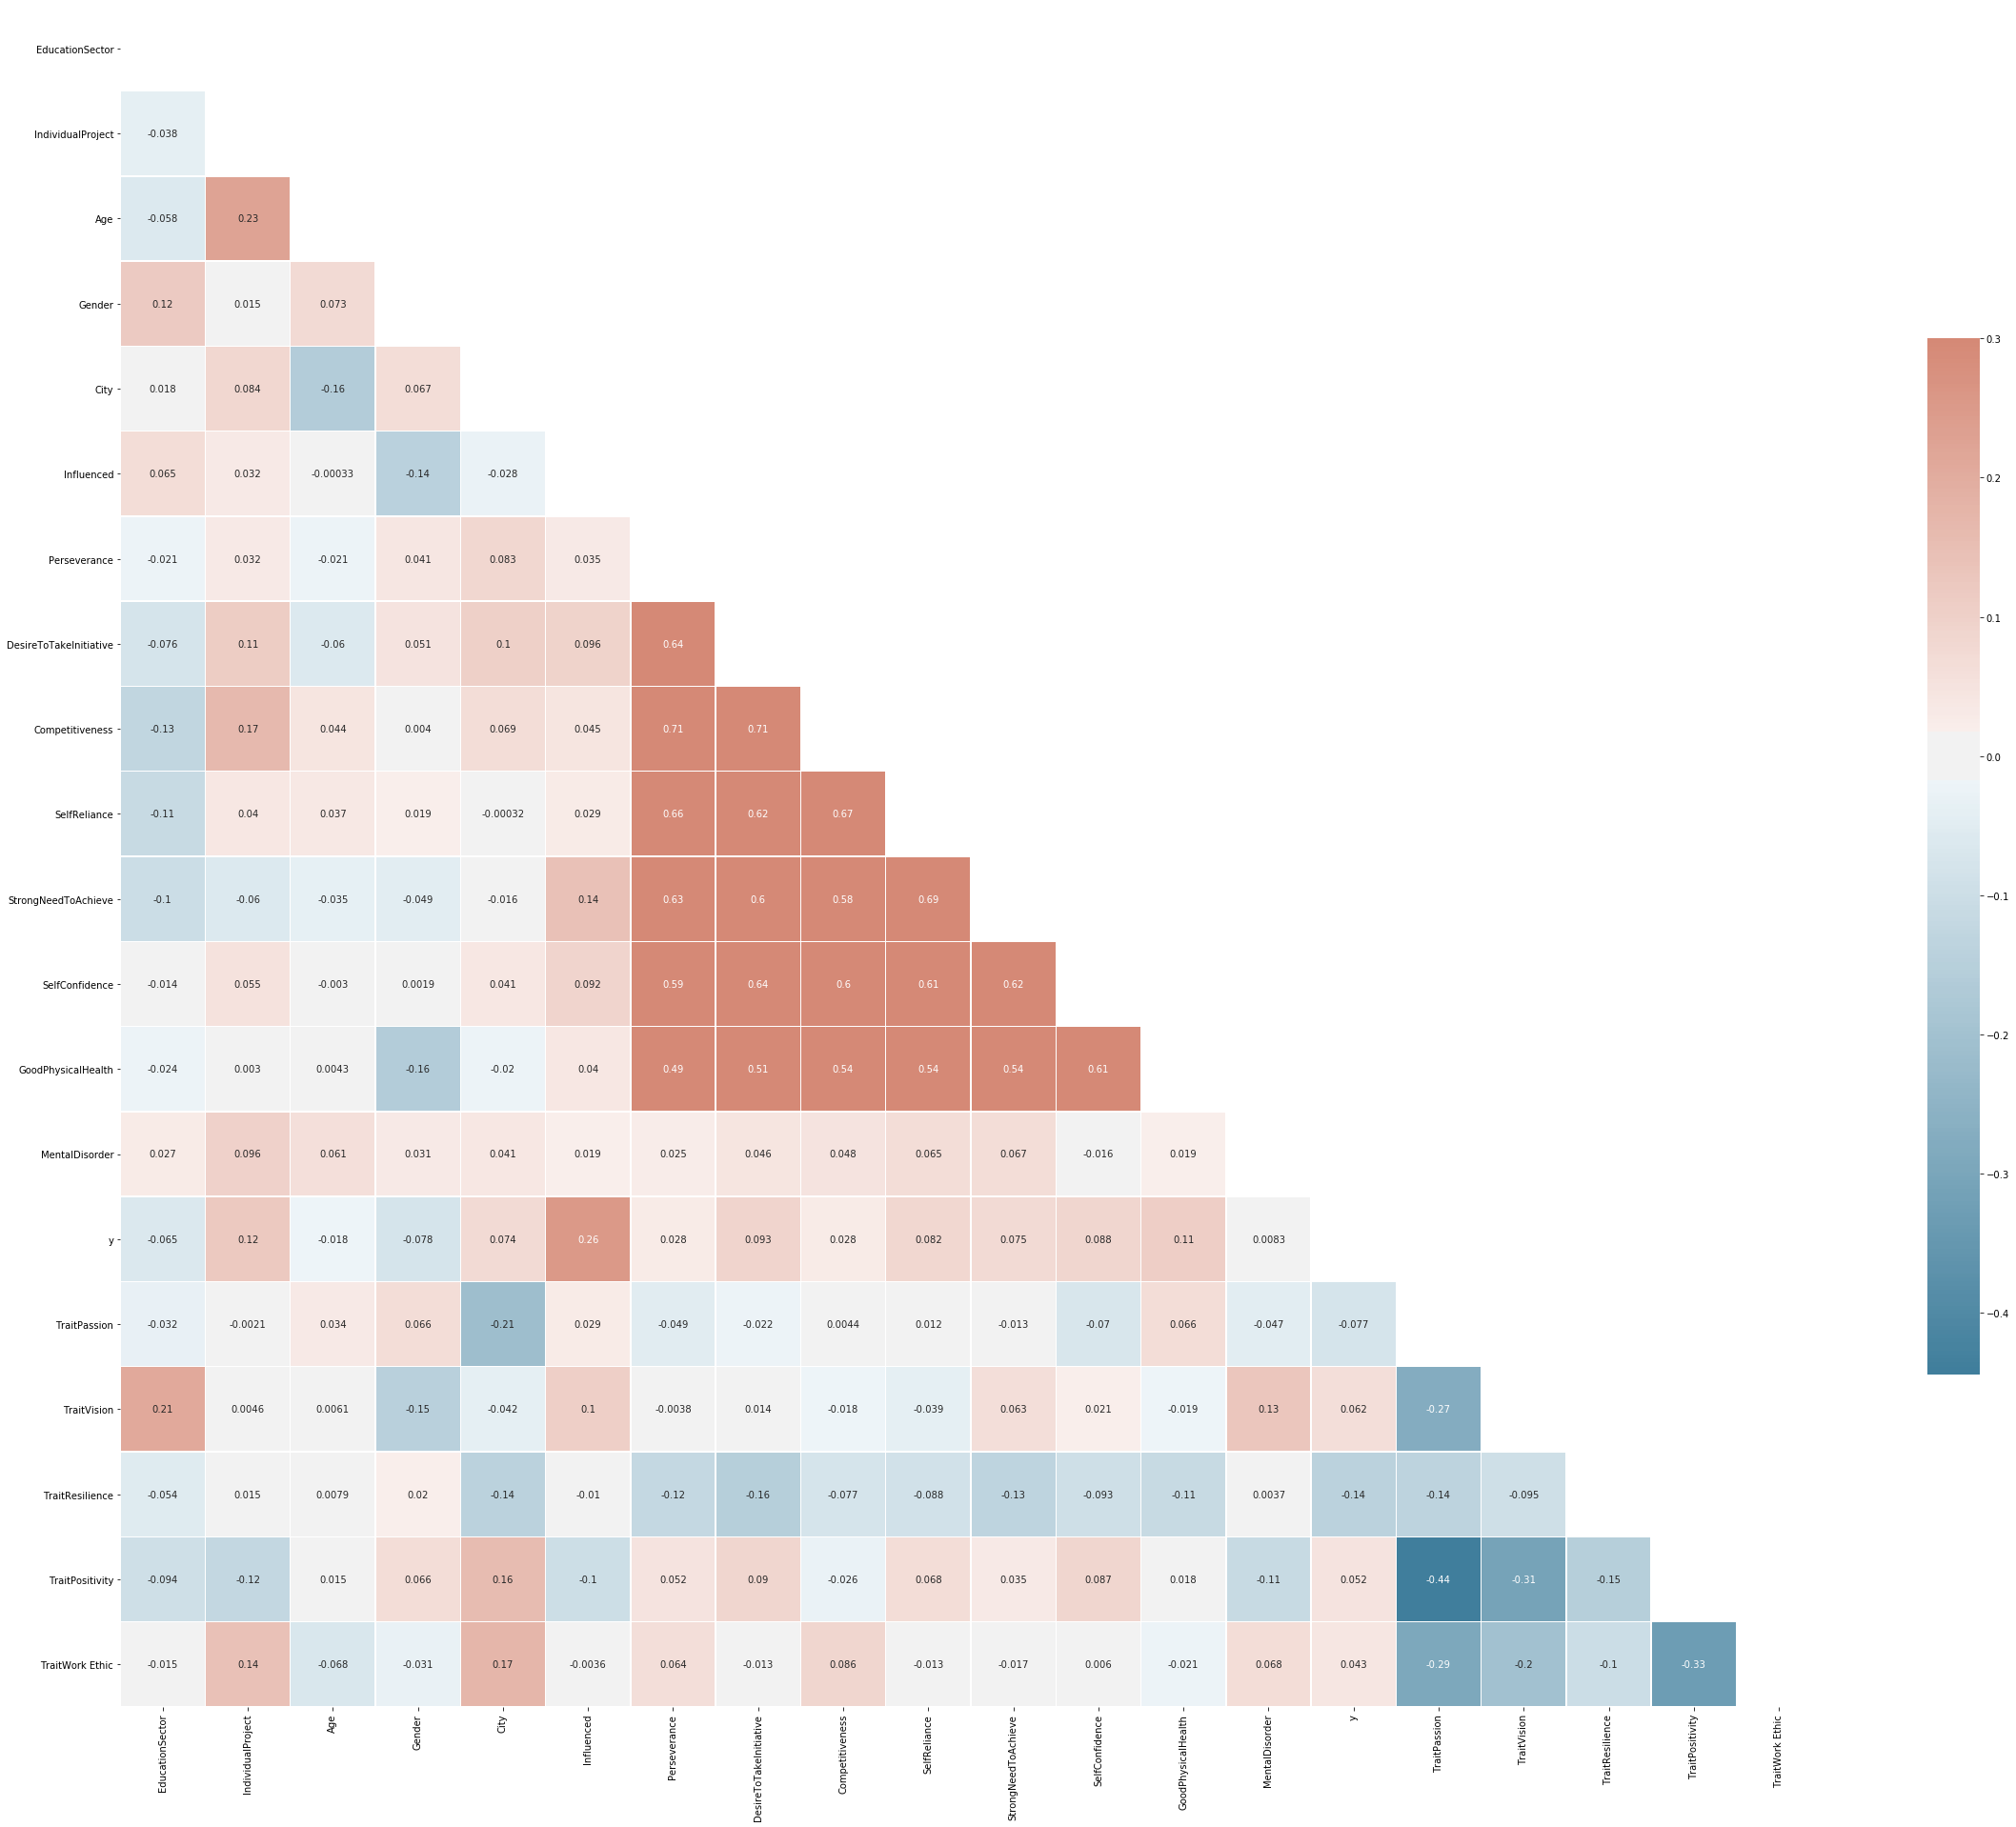

In [4]:
ind_map = {'Yes':True, 'No':False}
df['IndividualProject'] = df['IndividualProject'].map(ind_map)

gen_map = {'Male':1, 'Female':2}
df['Gender'] = df['Gender'].map(gen_map)

cit_map = {'Yes':True, 'No':False}
df['City'] = df['City'].map(cit_map)

inf_map = {'Yes':True, 'No':False}
df['Influenced'] = df['Influenced'].map(inf_map)

men_map = {'Yes':True, 'No':False}
df['MentalDisorder'] = df['MentalDisorder'].map(men_map)

for t in df['KeyTraits'].unique():
    df[f'Trait{t}'] = df['KeyTraits'] == t

education_map = {'Engineering Sciences':1, 'Others':2, 'Economic Sciences, Business Studies, Commerce and Law':3,
                 'Art, Music or Design':4, 'Humanities and Social Sciences':5, 'Medicine, Health Sciences':6, 
                 'Teaching Degree (e.g., B.Ed)':7, 'Mathematics or Natural Sciences':8, 'Language and Cultural Studies':9}
df['EducationSector'] = df['EducationSector'].map(education_map)

df.drop(columns=['ReasonsForLack'], inplace=True)

def display_correlation_matrix(data):
    """ Displays a correlation matrix for a dataset """
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(40, 40))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})
    

display_correlation_matrix(df)

Thanks to the correlation map we can select features that contribute the most to the outcome:
* Age
* Individual Project
* Gender
* City
* Influenced
* Desire To Take Initiative
* Strong Need To Achieve
* Good Physical Health

Since the number of columns is very high, from now on I'll use a filtered dataset with the same columns that I used for my custom model and possibly only few more. 


In [5]:
df.drop(columns=[f'Trait{t}' for t in df['KeyTraits'].unique()], inplace=True)
    
df = df[['Age', 'Gender', 'IndividualProject', 'City', 'Competitiveness',
           'DesireToTakeInitiative', 'Influenced', 'StrongNeedToAchieve',
           'GoodPhysicalHealth', 'y']]

sample = np.random.choice(df.index, size=int(len(df) * 0.8), replace=False)
train_data = df.iloc[sample]
test_data = df.drop(sample)
test_y = test_data['y']
test_data.drop(columns=['y'], inplace=True)

### My custom model

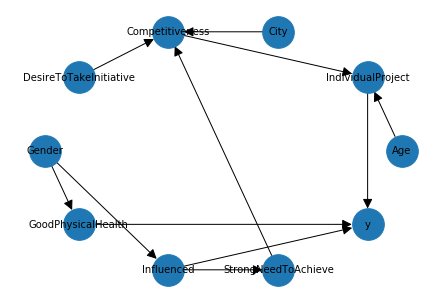

In [6]:
from pgmpy.models import BayesianModel

import networkx as nx

# Defining the network structure
custom_student_model = BayesianModel([('Age','IndividualProject'),
                                      ('City','Competitiveness'),
                                      ('DesireToTakeInitiative','Competitiveness'),
                                      ('Competitiveness', 'IndividualProject'),
                                      ('Gender','GoodPhysicalHealth'),
                                      ('Gender','Influenced'),
                                      ('Influenced', 'StrongNeedToAchieve'),
                                      ('StrongNeedToAchieve','Competitiveness'),
                                      ('Influenced', 'y'), 
                                      ('GoodPhysicalHealth', 'y'), 
                                      ('IndividualProject', 'y')])

nx.draw_circular(custom_student_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10)
plt.show()

## Structure Learning

### Score-based Structure Learning

  0%|          | 5/1000000 [00:00<54:35:18,  5.09it/s] 


Hill Climb Search with BDeu Score


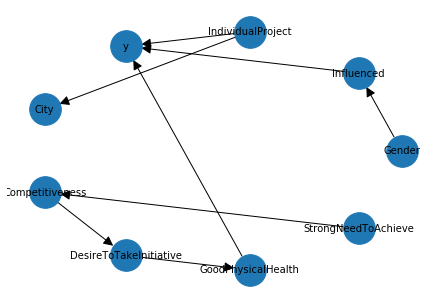

In [7]:
from pgmpy.estimators import HillClimbSearch, BDeuScore, K2Score

hc = HillClimbSearch(train_data)
hc_bds_model = BayesianModel(
    hc.estimate(
        scoring_method=BDeuScore(train_data), 
        fixed_edges=[('GoodPhysicalHealth', 'y'), ('Influenced', 'y'), ('IndividualProject', 'y')]
    )
    .edges())
print('Hill Climb Search with BDeu Score')
nx.draw_circular(hc_bds_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10)
plt.show()

  0%|          | 7/1000000 [00:01<52:29:17,  5.29it/s] 


Hill Climb Search with K2 Score


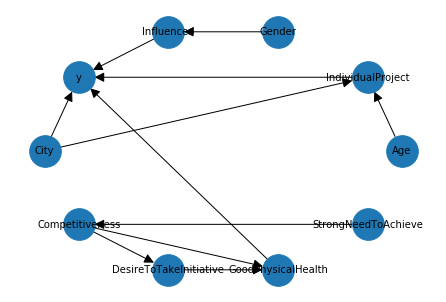

In [8]:
hc = HillClimbSearch(train_data)
hc_k2s_model = BayesianModel(
    hc.estimate(
        scoring_method=K2Score(train_data),
        fixed_edges=[('GoodPhysicalHealth', 'y'), ('Influenced', 'y'), ('IndividualProject', 'y')]
    )
    .edges())
print('Hill Climb Search with K2 Score')
nx.draw_circular(hc_k2s_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10)
plt.show()

### Parameter Estimation

In [9]:
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

def estimate_parameters(models, data):
    ''' 
    Given a list of models and the data
    uses MLE and Bayesian estimator to
    return a dictionary model -> pairs of cdps
    '''
    fitted = {}
    for name, model in models.items():
        mle = model.copy()
        mle.fit(data, estimator=MaximumLikelihoodEstimator)
        bay = model.copy()
        bay.fit(data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5)
        fitted[name] = (mle, bay)
    return fitted

In [10]:

models = {'custom': custom_student_model, 'HillClimbSearch-BDeuScore': hc_bds_model, 'HillClimbSearch-K2Score': hc_k2s_model}

fitted_models = estimate_parameters(models, train_data)


### Inference with Variable Elimination

In [11]:
from pgmpy.inference import VariableElimination

for name, (mle, bay) in fitted_models.items():
    inf = VariableElimination(mle)
    y_prob = inf.query(['y'])
    print(f'Maximum Likelihood estimator with model {name}')
    print(y_prob)
    inf = VariableElimination(bay)
    y_prob = inf.query(['y'])
    print(f'Bayesian estimator with model {name}')
    print(y_prob)
    
    

Eliminating: IndividualProject:   0%|          | 0/9 [00:00<?, ?it/s]

Maximum Likelihood estimator with model custom
+------+----------+
| y    |   phi(y) |
+======+==========+
| y(0) |   0.5471 |
+------+----------+
| y(1) |   0.4529 |
+------+----------+


Eliminating: IndividualProject:   0%|          | 0/9 [00:00<?, ?it/s]

Bayesian estimator with model custom
+------+----------+
| y    |   phi(y) |
+======+==========+
| y(0) |   0.5460 |
+------+----------+
| y(1) |   0.4540 |
+------+----------+
Maximum Likelihood estimator with model HillClimbSearch-BDeuScore
+------+----------+
| y    |   phi(y) |
+======+==========+
| y(0) |   0.5481 |
+------+----------+
| y(1) |   0.4519 |
+------+----------+
Bayesian estimator with model HillClimbSearch-BDeuScore
+------+----------+
| y    |   phi(y) |
+======+==========+
| y(0) |   0.5470 |
+------+----------+
| y(1) |   0.4530 |
+------+----------+


Eliminating: GoodPhysicalHealth: 100%|██████████| 9/9 [00:00<00:00, 107.43it/s]

Maximum Likelihood estimator with model HillClimbSearch-K2Score
+------+----------+
| y    |   phi(y) |
+======+==========+
| y(0) |   0.5421 |
+------+----------+
| y(1) |   0.4579 |
+------+----------+
Bayesian estimator with model HillClimbSearch-K2Score
+------+----------+
| y    |   phi(y) |
+======+==========+
| y(0) |   0.5425 |
+------+----------+
| y(1) |   0.4575 |
+------+----------+


## Prediction

In [12]:
import numpy as np

for name, (mle, bay) in fitted_models.items():
    columns = list(mle.nodes)
    columns.remove('y')
    y_pred = mle.predict(test_data[columns])['y']
    # print(y_pred)
    print(f'Maximum Likelihood estimator with model {name}')
    print(f'{(np.array(y_pred) == np.array(test_y)).sum()}/{len(test_data)}')
    y_pred = bay.predict(test_data[columns])['y']
    # print(y_pred)
    print(f'Bayesian estimator with model {name}')
    print(f'{(np.array(y_pred) == np.array(test_y)).sum()}/{len(test_data)}')
    
    

 19%|█▉        | 8/42 [00:00<00:00, 55.70it/s]

Maximum Likelihood estimator with model custom
30/44


  0%|          | 0/42 [00:00<?, ?it/s]

Bayesian estimator with model custom
30/44


 38%|███▊      | 16/42 [00:00<00:00, 156.41it/s]

Maximum Likelihood estimator with model HillClimbSearch-BDeuScore
30/44


 29%|██▊       | 12/42 [00:00<00:00, 113.68it/s]

Bayesian estimator with model HillClimbSearch-BDeuScore
30/44


 19%|█▉        | 8/42 [00:00<00:00, 56.82it/s]

Maximum Likelihood estimator with model HillClimbSearch-K2Score
33/44


100%|██████████| 42/42 [00:00<00:00, 44.96it/s]


Bayesian estimator with model HillClimbSearch-K2Score
33/44
